In [16]:
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import zscore

from imblearn.over_sampling import SMOTE

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
import mlflow
import mlflow.sklearn

from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from collections import Counter

from datetime import datetime
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)

%run "../../src/data_preparation/utils.py"
%run "../../src/data_preparation/common_eda.py"
%run "../../src/visualization/common_visualization.py"
path_to_data = "../../data/raw/"

print(os.getcwd())

/data/zmining/jupyter-notebook/chaupm3/solar_flare/notebooks/modelling


In [2]:
def lgb_f1_score(y_true, y_pred):
    y_pred = np.round(y_pred) # scikits f1 doesn't like probabilities
    return 'ff1', f1_score(y_true, y_pred), True

In [3]:
extra1 = pd.read_csv("../../data/processed/fold1.csv")
extra2 = pd.read_csv("../../data/processed/fold2.csv")
extra3 = pd.read_csv("../../data/processed/fold3.csv")
extra_submission = pd.read_csv("../../data/processed/fold_test.csv")

print(extra1.shape, extra2.shape, extra3.shape, extra_submission.shape)

(76773, 176) (92481, 176) (27006, 176) (173512, 176)


In [4]:
df1 = pd.read_csv("../../data/processed/fold1Training_60.csv")
df2 = pd.read_csv("../../data/processed/fold2Training_60.csv")
df3 = pd.read_csv("../../data/processed/fold3Training_60.csv")
df_submission = pd.read_csv("../../data/processed/testSet_60.csv")

print(df1.shape, df2.shape, df3.shape, df_submission.shape)

(76773, 1502) (92481, 1502) (27006, 1502) (173512, 1502)


In [5]:
c1 = Counter(df1.LABEL)
c2 = Counter(df2.LABEL)
c3 = Counter(df3.LABEL)

print("df1", df1.shape, c1, c1[1]*100/ (c1[1] + c1[0]))
print("df2", df2.shape,c2, c2[1]*100/ (c2[1] + c2[0]))
print("df3", df3.shape,c3, c3[1]*100/ (c3[1] + c3[0]))

# fold 1: 76,773 objects; class 1 /class 0 ≈ 19.5%
# • fold 2: 92,481 objects; class 1 /class 0 ≈ 17.8%
# • fold 3: 27,006 objects; class 1 /class 0 ≈ 21.5%

df1 (76773, 1502) Counter({0: 64222, 1: 12551}) 16.348195329087048
df2 (92481, 1502) Counter({0: 78516, 1: 13965}) 15.100399000875855
df3 (27006, 1502) Counter({0: 22236, 1: 4770}) 17.662741612974894


In [6]:
train = pd.merge(df1, extra1, on="ID", how="inner")
valid =  pd.merge(df2, extra2, on="ID", how="inner")
test = pd.merge(df3, extra3, on="ID", how="inner")
submission =  pd.merge(df_submission, extra_submission, on="ID", how="inner")

c_train = Counter(train.LABEL)
c_valid = Counter(valid.LABEL)
c_test = Counter(test.LABEL)
print("c_train", train.shape, c_train, c_train[1]*100/c_train[0])
print("c_valid", valid.shape, c_valid, c_valid[1]*100/c_valid[0])
print("c_test", test.shape, c_test, c_test[1]*100/c_test[0])
print("submission.shape = ", submission.shape)

c_train (76773, 1677) Counter({0: 64222, 1: 12551}) 19.543147208121827
c_valid (92481, 1677) Counter({0: 78516, 1: 13965}) 17.786183707779305
c_test (27006, 1677) Counter({0: 22236, 1: 4770}) 21.45169994603346
submission.shape =  (173512, 1677)


In [7]:
total_cols =  list(train.iloc[:, :-2].columns.values) 

In [54]:
# print(len(list(extra1.drop("ID",1).columns)))
# extra_cols= []
# print(len(extra_cols))
# for c in list(extra1.drop("ID",1).columns):
#     if "SUM" not in c:
#         extra_cols.append(c)
# print(len(extra_cols))
# print(extra_cols)

175
0
150
['MAX(data.TOTUSJH)', 'MAX(data.TOTBSQ)', 'MAX(data.TOTPOT)', 'MAX(data.TOTUSJZ)', 'MAX(data.ABSNJZH)', 'MAX(data.SAVNCPP)', 'MAX(data.USFLUX)', 'MAX(data.TOTFZ)', 'MAX(data.MEANPOT)', 'MAX(data.EPSZ)', 'MAX(data.MEANSHR)', 'MAX(data.SHRGT45)', 'MAX(data.MEANGAM)', 'MAX(data.MEANGBT)', 'MAX(data.MEANGBZ)', 'MAX(data.MEANGBH)', 'MAX(data.MEANJZH)', 'MAX(data.TOTFY)', 'MAX(data.MEANJZD)', 'MAX(data.MEANALP)', 'MAX(data.TOTFX)', 'MAX(data.EPSY)', 'MAX(data.EPSX)', 'MAX(data.R_VALUE)', 'MAX(data.XR_MAX)', 'MIN(data.TOTUSJH)', 'MIN(data.TOTBSQ)', 'MIN(data.TOTPOT)', 'MIN(data.TOTUSJZ)', 'MIN(data.ABSNJZH)', 'MIN(data.SAVNCPP)', 'MIN(data.USFLUX)', 'MIN(data.TOTFZ)', 'MIN(data.MEANPOT)', 'MIN(data.EPSZ)', 'MIN(data.MEANSHR)', 'MIN(data.SHRGT45)', 'MIN(data.MEANGAM)', 'MIN(data.MEANGBT)', 'MIN(data.MEANGBZ)', 'MIN(data.MEANGBH)', 'MIN(data.MEANJZH)', 'MIN(data.TOTFY)', 'MIN(data.MEANJZD)', 'MIN(data.MEANALP)', 'MIN(data.TOTFX)', 'MIN(data.EPSY)', 'MIN(data.EPSX)', 'MIN(data.R_VALUE)

In [69]:
ori = ['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ', 'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE', 'XR_MAX']
ori_cols = [c + "_59" for c in ori] #+ [c + "_58" for c in ori]

selected_cols_1 = [c for c in total_cols if 'TOTU' in c] 
selected_cols_2 = []   #[c for c in total_cols if 'ABSNJZH' in c] 
selected_cols_3 = []   #[c for c in total_cols if 'USFLUX' in c] 
selected_cols_4 = []   #[c for c in total_cols if 'SAVNCPP' in c] 


# extra_cols = extra_cols
extra_cols = list(extra1.drop("ID",1).columns)
                  
                  
feature_cols = ori_cols + selected_cols_1 + selected_cols_2 + selected_cols_3 + selected_cols_4 + extra_cols + ["MAX(data.R_VALUE) < 1.5", "MAX(data.R_VALUE) + MAX(data.USFLUX)", "MAX(data.R_VALUE) * MAX(data.USFLUX)"] 
feature_cols = list(set(feature_cols))

print(len(feature_cols))

321


In [70]:
feature_cols

['TOTUSJZ_33',
 'MEDIAN(data.ABSNJZH)',
 'TOTUSJZ_42',
 'TOTUSJH_17',
 'TOTUSJH_14',
 'MIN(data.TOTPOT)',
 'SKEW(data.TOTUSJH)',
 'STD(data.XR_MAX)',
 'MIN(data.EPSZ)',
 'TOTUSJH_58',
 'STD(data.R_VALUE)',
 'MAX(data.R_VALUE) * MAX(data.USFLUX)',
 'MEDIAN(data.MEANGBT)',
 'MIN(data.ABSNJZH)',
 'MIN(data.MEANPOT)',
 'MIN(data.MEANALP)',
 'SKEW(data.EPSZ)',
 'TOTUSJZ_25',
 'MEAN(data.MEANJZH)',
 'TOTUSJH_41',
 'MEAN(data.USFLUX)',
 'SUM(data.R_VALUE)',
 'MEAN(data.EPSX)',
 'TOTUSJH_9',
 'MAX(data.MEANJZD)',
 'MEDIAN(data.MEANGBZ)',
 'TOTUSJH_10',
 'TOTBSQ_59',
 'TOTUSJZ_55',
 'TOTFX_59',
 'TOTUSJZ_8',
 'MAX(data.TOTFX)',
 'SKEW(data.MEANGAM)',
 'TOTUSJZ_10',
 'MEAN(data.MEANALP)',
 'MIN(data.MEANGAM)',
 'TOTUSJH_19',
 'MIN(data.TOTFY)',
 'MEAN(data.ABSNJZH)',
 'STD(data.MEANGBT)',
 'TOTUSJH_52',
 'TOTUSJZ_36',
 'R_VALUE_59',
 'TOTUSJH_53',
 'SKEW(data.MEANPOT)',
 'MAX(data.R_VALUE) + MAX(data.USFLUX)',
 'TOTUSJZ_24',
 'MIN(data.TOTFZ)',
 'TOTUSJZ_7',
 'TOTUSJZ_17',
 'SKEW(data.TOTBSQ)',
 'TOTUSJH_57',
 'SKEW(data.MEANGBZ)',
 'MEAN(data.SAVNCPP)',
 'STD(data.MEANSHR)',
 'MEDIAN(data.MEANSHR)',
 'STD(data.MEANGBH)',
 'TOTUSJH_44',
 'TOTUSJH_34',
 'MAX(data.SHRGT45)',
 'STD(data.MEANGAM)',
 'STD(data.TOTFX)',
 'SKEW(data.EPSX)',
 'TOTUSJZ_48',
 'TOTUSJH_30',
 'MAX(data.MEANGBZ)',
 'TOTUSJH_31',
 'MEDIAN(data.TOTFX)',
 'MAX(data.ABSNJZH)',
 'TOTUSJH_20',
 'MEDIAN(data.MEANGAM)',
 'MIN(data.EPSX)',
 'STD(data.USFLUX)',
 'MEDIAN(data.R_VALUE)',
 'TOTUSJH_15',
 'TOTUSJH_25',
 'MEAN(data.MEANGBH)',
 'MIN(data.EPSY)',
 'TOTUSJH_32',
 'TOTUSJZ_39',
 'SUM(data.TOTUSJZ)',
 'TOTUSJH_11',
 'SKEW(data.TOTFZ)',
 'TOTUSJZ_3',
 'MAX(data.TOTFZ)',
 'MAX(data.TOTFY)',
 'MEDIAN(data.MEANALP)',
 'TOTUSJZ_43',
 'MEANGAM_59',
 'TOTUSJH_39',
 'TOTUSJZ_46',
 'TOTUSJH_49',
 'TOTUSJZ_19',
 'MAX(data.EPSY)',
 'MEAN(data.MEANPOT)',
 'MEDIAN(data.EPSY)',
 'MEAN(data.EPSZ)',
 'TOTUSJH_16',
 'XR_MAX_59',
 'MEDIAN(data.EPSZ)',
 'TOTUSJZ_4',
 'TOTUSJH_43',
 'TOTUSJH_47',
 'STD(data.SAVNCPP)',
 'TOTFY_59',
 'MIN(data.TOTBSQ)',
 'SKEW(data.USFLUX)',
 'SKEW(data.MEANGBH)',
 'STD(data.TOTUSJH)',
 'MEDIAN(data.MEANJZD)',
 'TOTUSJH_51',
 'TOTUSJH_54',
 'MAX(data.TOTPOT)',
 'MAX(data.MEANGBH)',
 'MIN(data.MEANGBT)',
 'MIN(data.MEANGBZ)',
 'MIN(data.MEANJZD)',
 'MEAN(data.TOTFX)',
 'TOTUSJH_36',
 'TOTUSJZ_30',
 'MIN(data.TOTUSJH)',
 'TOTUSJZ_31',
 'EPSZ_59',
 'TOTUSJZ_52',
 'MAX(data.EPSX)',
 'STD(data.MEANJZH)',
 'TOTUSJZ_45',
 'SUM(data.MEANJZD)',
 'TOTUSJH_48',
 'MAX(data.XR_MAX)',
 'MEDIAN(data.XR_MAX)',
 'MEDIAN(data.TOTFZ)',
 'TOTUSJH_27',
 'EPSX_59',
 'TOTUSJH_50',
 'SUM(data.TOTBSQ)',
 'MEAN(data.XR_MAX)',
 'SAVNCPP_59',
 'MEAN(data.EPSY)',
 'STD(data.TOTUSJZ)',
 'TOTUSJH_7',
 'MEANJZD_59',
 'TOTUSJH_21',
 'TOTUSJZ_40',
 'SUM(data.MEANGBT)',
 'TOTFZ_59',
 'SHRGT45_59',
 'TOTUSJZ_32',
 'TOTUSJH_24',
 'MEDIAN(data.EPSX)',
 'MAX(data.MEANGBT)',
 'SUM(data.ABSNJZH)',
 'SUM(data.EPSZ)',
 'SUM(data.TOTPOT)',
 'MEDIAN(data.SHRGT45)',
 'MEANSHR_59',
 'TOTUSJH_1',
 'SKEW(data.MEANSHR)',
 'SKEW(data.SHRGT45)',
 'MAX(data.MEANGAM)',
 'SKEW(data.EPSY)',
 'MIN(data.SHRGT45)',
 'TOTUSJH_29',
 'TOTUSJH_46',
 'SKEW(data.XR_MAX)',
 'TOTUSJH_13',
 'TOTUSJH_28',
 'TOTUSJH_4',
 'TOTUSJH_35',
 'MAX(data.TOTUSJZ)',
 'MAX(data.SAVNCPP)',
 'MEAN(data.MEANSHR)',
 'MEAN(data.MEANGBT)',
 'STD(data.TOTFZ)',
 'MEDIAN(data.TOTUSJH)',
 'STD(data.EPSZ)',
 'SUM(data.USFLUX)',
 'STD(data.ABSNJZH)',
 'TOTUSJH_12',
 'TOTUSJZ_18',
 'SKEW(data.TOTUSJZ)',
 'TOTPOT_59',
 'SKEW(data.ABSNJZH)',
 'TOTUSJZ_37',
 'STD(data.MEANPOT)',
 'TOTUSJZ_44',
 'MAX(data.R_VALUE) < 1.5',
 'TOTUSJZ_2',
 'TOTUSJH_3',
 'TOTUSJZ_5',
 'TOTUSJZ_22',
 'SUM(data.MEANGBH)',
 'TOTUSJH_33',
 'TOTUSJZ_26',
 'MEDIAN(data.MEANPOT)',
 'STD(data.EPSX)',
 'TOTUSJZ_56',
 'MAX(data.MEANJZH)',
 'STD(data.MEANGBZ)',
 'TOTUSJZ_20',
 'TOTUSJH_26',
 'MEDIAN(data.MEANJZH)',
 'SKEW(data.TOTFX)',
 'TOTUSJZ_21',
 'TOTUSJH_40',
 'MAX(data.R_VALUE)',
 'TOTUSJZ_11',
 'MEDIAN(data.MEANGBH)',
 'MEANALP_59',
 'MAX(data.USFLUX)',
 'MEAN(data.MEANJZD)',


## Normalization

In [ ]:
missing_exploration(train)

In [15]:
# df = train.copy()
# cols = list(df.columns)[:-175]
# df[cols]
# for col in cols:
#     col_zscore = col + '_zscore'
#     df[col_zscore] = (df[col] - df[col].mean())/df[col].std()

In [ ]:
# train = train.apply(zscore)
# valid = valid.apply(lambda x: x if np.std(x) == 0 else zscore(x))
# test = test.apply(lambda x: x if np.std(x) == 0 else zscore(x))
# submission = submission.apply(lambda x: x if np.std(x) == 0 else zscore(x))

In [40]:
 train.head()

,TOTUSJH_0,TOTBSQ_0,TOTPOT_0,TOTUSJZ_0,ABSNJZH_0,SAVNCPP_0,USFLUX_0,TOTFZ_0,MEANPOT_0,EPSZ_0,MEANSHR_0,SHRGT45_0,MEANGAM_0,MEANGBT_0,MEANGBZ_0,MEANGBH_0,MEANJZH_0,TOTFY_0,MEANJZD_0,MEANALP_0,TOTFX_0,EPSY_0,EPSX_0,R_VALUE_0,XR_MAX_0,TOTUSJH_1,TOTBSQ_1,TOTPOT_1,TOTUSJZ_1,ABSNJZH_1,SAVNCPP_1,USFLUX_1,TOTFZ_1,MEANPOT_1,EPSZ_1,MEANSHR_1,SHRGT45_1,MEANGAM_1,MEANGBT_1,MEANGBZ_1,MEANGBH_1,MEANJZH_1,TOTFY_1,MEANJZD_1,MEANALP_1,TOTFX_1,EPSY_1,EPSX_1,R_VALUE_1,XR_MAX_1,TOTUSJH_2,TOTBSQ_2,TOTPOT_2,TOTUSJZ_2,ABSNJZH_2,SAVNCPP_2,USFLUX_2,TOTFZ_2,MEANPOT_2,EPSZ_2,MEANSHR_2,SHRGT45_2,MEANGAM_2,MEANGBT_2,MEANGBZ_2,MEANGBH_2,MEANJZH_2,TOTFY_2,MEANJZD_2,MEANALP_2,TOTFX_2,EPSY_2,EPSX_2,R_VALUE_2,XR_MAX_2,TOTUSJH_3,TOTBSQ_3,TOTPOT_3,TOTUSJZ_3,ABSNJZH_3,SAVNCPP_3,USFLUX_3,TOTFZ_3,MEANPOT_3,EPSZ_3,MEANSHR_3,SHRGT45_3,MEANGAM_3,MEANGBT_3,MEANGBZ_3,MEANGBH_3,MEANJZH_3,TOTFY_3,MEANJZD_3,MEANALP_3,TOTFX_3,EPSY_3,EPSX_3,R_VALUE_3,XR_MAX_3,TOTUSJH_4,TOTBSQ_4,TOTPOT_4,TOTUSJZ_4,ABSNJZH_4,SAVNCPP_4,USFLUX_4,TOTFZ_4,MEANPOT_4,EPSZ_4,MEANSHR_4,SHRGT45_4,MEANGAM_4,MEANGBT_4,MEANGBZ_4,MEANGBH_4,MEANJZH_4,TOTFY_4,MEANJZD_4,MEANALP_4,TOTFX_4,EPSY_4,EPSX_4,R_VALUE_4,XR_MAX_4,TOTUSJH_5,TOTBSQ_5,TOTPOT_5,TOTUSJZ_5,ABSNJZH_5,SAVNCPP_5,USFLUX_5,TOTFZ_5,MEANPOT_5,EPSZ_5,MEANSHR_5,SHRGT45_5,MEANGAM_5,MEANGBT_5,MEANGBZ_5,MEANGBH_5,MEANJZH_5,TOTFY_5,MEANJZD_5,MEANALP_5,TOTFX_5,EPSY_5,EPSX_5,R_VALUE_5,XR_MAX_5,TOTUSJH_6,TOTBSQ_6,TOTPOT_6,TOTUSJZ_6,ABSNJZH_6,SAVNCPP_6,USFLUX_6,TOTFZ_6,MEANPOT_6,EPSZ_6,MEANSHR_6,SHRGT45_6,MEANGAM_6,MEANGBT_6,MEANGBZ_6,MEANGBH_6,MEANJZH_6,TOTFY_6,MEANJZD_6,MEANALP_6,TOTFX_6,EPSY_6,EPSX_6,R_VALUE_6,XR_MAX_6,TOTUSJH_7,TOTBSQ_7,TOTPOT_7,TOTUSJZ_7,ABSNJZH_7,SAVNCPP_7,USFLUX_7,TOTFZ_7,MEANPOT_7,EPSZ_7,MEANSHR_7,SHRGT45_7,MEANGAM_7,MEANGBT_7,MEANGBZ_7,MEANGBH_7,MEANJZH_7,TOTFY_7,MEANJZD_7,MEANALP_7,TOTFX_7,EPSY_7,EPSX_7,R_VALUE_7,XR_MAX_7,TOTUSJH_8,TOTBSQ_8,TOTPOT_8,TOTUSJZ_8,ABSNJZH_8,SAVNCPP_8,USFLUX_8,TOTFZ_8,MEANPOT_8,EPSZ_8,MEANSHR_8,SHRGT45_8,MEANGAM_8,MEANGBT_8,MEANGBZ_8,MEANGBH_8,MEANJZH_8,TOTFY_8,MEANJZD_8,MEANALP_8,TOTFX_8,EPSY_8,EPSX_8,R_VALUE_8,XR_MAX_8,TOTUSJH_9,TOTBSQ_9,TOTPOT_9,TOTUSJZ_9,ABSNJZH_9,SAVNCPP_9,USFLUX_9,TOTFZ_9,MEANPOT_9,EPSZ_9,MEANSHR_9,SHRGT45_9,MEANGAM_9,MEANGBT_9,MEANGBZ_9,MEANGBH_9,MEANJZH_9,TOTFY_9,MEANJZD_9,MEANALP_9,TOTFX_9,EPSY_9,EPSX_9,R_VALUE_9,XR_MAX_9,...,TOTPOT_57,TOTUSJZ_57,ABSNJZH_57,SAVNCPP_57,USFLUX_57,TOTFZ_57,MEANPOT_57,EPSZ_57,MEANSHR_57,SHRGT45_57,MEANGAM_57,MEANGBT_57,MEANGBZ_57,MEANGBH_57,MEANJZH_57,TOTFY_57,MEANJZD_57,MEANALP_57,TOTFX_57,EPSY_57,EPSX_57,R_VALUE_57,XR_MAX_57,TOTUSJH_58,TOTBSQ_58,TOTPOT_58,TOTUSJZ_58,ABSNJZH_58,SAVNCPP_58,USFLUX_58,TOTFZ_58,MEANPOT_58,EPSZ_58,MEANSHR_58,SHRGT45_58,MEANGAM_58,MEANGBT_58,MEANGBZ_58,MEANGBH_58,MEANJZH_58,TOTFY_58,MEANJZD_58,MEANALP_58,TOTFX_58,EPSY_58,EPSX_58,R_VALUE_58,XR_MAX_58,TOTUSJH_59,TOTBSQ_59,TOTPOT_59,TOTUSJZ_59,ABSNJZH_59,SAVNCPP_59,USFLUX_59,TOTFZ_59,MEANPOT_59,EPSZ_59,MEANSHR_59,SHRGT45_59,MEANGAM_59,MEANGBT_59,MEANGBZ_59,MEANGBH_59,MEANJZH_59,TOTFY_59,MEANJZD_59,MEANALP_59,TOTFX_59,EPSY_59,EPSX_59,R_VALUE_59,XR_MAX_59,LABEL,ID,SUM(data.TOTUSJH),SUM(data.TOTBSQ),SUM(data.TOTPOT),SUM(data.TOTUSJZ),SUM(data.ABSNJZH),SUM(data.SAVNCPP),SUM(data.USFLUX),SUM(data.TOTFZ),SUM(data.MEANPOT),SUM(data.EPSZ),SUM(data.MEANSHR),SUM(data.SHRGT45),SUM(data.MEANGAM),SUM(data.MEANGBT),SUM(data.MEANGBZ),SUM(data.MEANGBH),SUM(data.MEANJZH),SUM(data.TOTFY),SUM(data.MEANJZD),SUM(data.MEANALP),SUM(data.TOTFX),SUM(data.EPSY),SUM(data.EPSX),SUM(data.R_VALUE),SUM(data.XR_MAX),MAX(data.TOTUSJH),MAX(data.TOTBSQ),MAX(data.TOTPOT),MAX(data.TOTUSJZ),MAX(data.ABSNJZH),MAX(data.SAVNCPP),MAX(data.USFLUX),MAX(data.TOTFZ),MAX(data.MEANPOT),MAX(data.EPSZ),MAX(data.MEANSHR),MAX(data.SHRGT45),MAX(data.MEANGAM),MAX(data.MEANGBT),MAX(data.MEANGBZ),MAX(data.MEANGBH),MAX(data.MEANJZH),MAX(data.TOTFY),MAX(data.MEANJZD),MAX(data.MEANALP),MAX(data.TOTFX),MAX(data.EPSY),MAX(data.EPSX),MAX(data.R_VALUE),MAX(data.XR_MAX),MIN(data.TOTUSJH),MIN(data.TOTBSQ),MIN(data.TOTPOT),MIN(data.TOTUSJ

## FINAL 

num feature_cols = 321 
Training until validation scores don't improve for 300 rounds.
[100]	train's binary_logloss: 0.392593	train's ff1: 0.650654	valid's binary_logloss: 0.350218	valid's ff1: 0.692013
[200]	train's binary_logloss: 0.332789	train's ff1: 0.662405	valid's binary_logloss: 0.309921	valid's ff1: 0.683368
[300]	train's binary_logloss: 0.311346	train's ff1: 0.665362	valid's binary_logloss: 0.298723	valid's ff1: 0.685892
Early stopping, best iteration is:
[57]	train's binary_logloss: 0.452719	train's ff1: 0.570701	valid's binary_logloss: 0.390322	valid's ff1: 0.721073
done in  0:00:58.769031


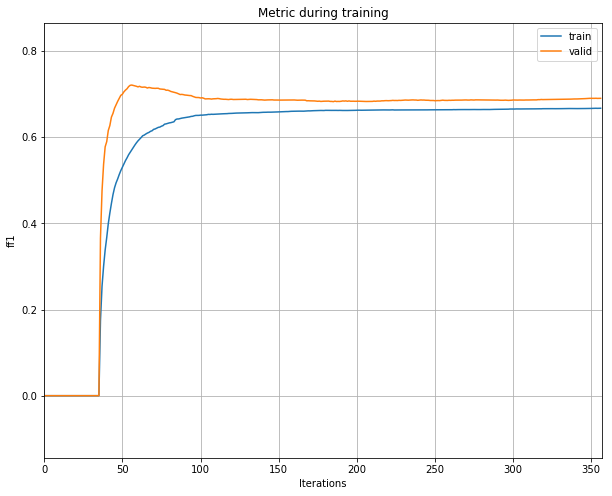

In [71]:
n_jobs = 8
feature_cols = feature_cols
cate_cols = list()
early_stopping = 300

using_SMOTE = False

feature_cols = feature_cols
cate_cols = list()

train_valid = pd.concat([train, valid]).reset_index(drop=True)

train_valid["MAX(data.R_VALUE) < 1.5"] =  train_valid["MAX(data.R_VALUE)"] < 1.5
test["MAX(data.R_VALUE) < 1.5"] =  test["MAX(data.R_VALUE)"] < 1.5
submission["MAX(data.R_VALUE) < 1.5"] =  submission["MAX(data.R_VALUE)"] < 1.5

train_valid["MAX(data.R_VALUE) * MAX(data.USFLUX)"] =train_valid["MAX(data.R_VALUE)"] * train_valid["MAX(data.USFLUX)"]
test["MAX(data.R_VALUE) * MAX(data.USFLUX)"] =test["MAX(data.R_VALUE)"] * test["MAX(data.USFLUX)"]
submission["MAX(data.R_VALUE) * MAX(data.USFLUX)"] =submission["MAX(data.R_VALUE)"] * submission["MAX(data.USFLUX)"]

train_valid["MAX(data.R_VALUE) + MAX(data.USFLUX)"] =train_valid["MAX(data.R_VALUE)"] + train_valid["MAX(data.USFLUX)"]
test["MAX(data.R_VALUE) + MAX(data.USFLUX)"] =test["MAX(data.R_VALUE)"] + test["MAX(data.USFLUX)"]
submission["MAX(data.R_VALUE) + MAX(data.USFLUX)"] =submission["MAX(data.R_VALUE)"] + submission["MAX(data.USFLUX)"]


X_train, y_train  = train_valid[feature_cols], train_valid.LABEL
X_valid, y_valid  = test[feature_cols], test.LABEL
X_submission = submission[feature_cols]


weight = c_train[0]/c_train[1]/2

if using_SMOTE:
    smt = SMOTE(random_state=2019)
    X_train, y_train = smt.fit_sample(X_train.fillna(0), y_train)
    weight = 1

    


####################
## RUN THE MODEL ##
###################

## NO need to edit this cell ##

start_time = datetime.now()

random_seed = 2019

print("num feature_cols = {} ".format(len(feature_cols)))

## prepare the model
lgb_params = {
    'boosting_type':'gbdt', 'colsample_bytree':0.5, 'class_weight': {0 : 1. , 1: weight},
    'importance_type':'gain', 'learning_rate':0.01, 'max_depth':3,
    'min_child_samples':20,# 'min_child_weight':0.001, 'min_split_gain':0.0,
    'n_estimators':20000, 'n_jobs': n_jobs, 'num_leaves':31, 'subsample_freq':16,
    'seed': random_seed, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True,
    'subsample':0.5, 'subsample_for_bin':200000,  "metric": ["ff1", "binary_logloss"] ,'objective':"binary"
}

lgb_model = lgb.LGBMClassifier(**lgb_params)


record_store = dict()
lgb_model.fit( X=X_train, y=y_train, feature_name = feature_cols, #categorical_feature = cate_cols, 
              early_stopping_rounds= early_stopping, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              eval_names=["train", "valid"],
              eval_metric= lgb_f1_score,
              verbose = 100, callbacks = [lgb.record_evaluation(record_store)])

# calc loss error for valid set
y_pred = lgb_model.predict(X_valid)
y_pred_prob = lgb_model.predict_proba(X_valid)


oof = pd.concat([X_valid, y_valid], 1)
oof['pred'] = y_pred
oof['prob_0'] = y_pred_prob[:,0]
oof['prob_1'] = y_pred_prob[:,1]

# plot learning curve 
f = lgb.plot_metric(record_store, figsize=(10,8))
training_time = datetime.now() - start_time

print("done in ", training_time)

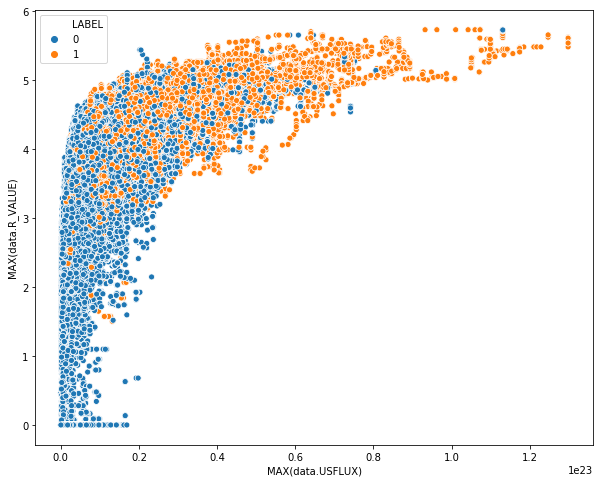

In [112]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="MAX(data.USFLUX)", y="MAX(data.R_VALUE)", hue="LABEL", data=train_valid)

125


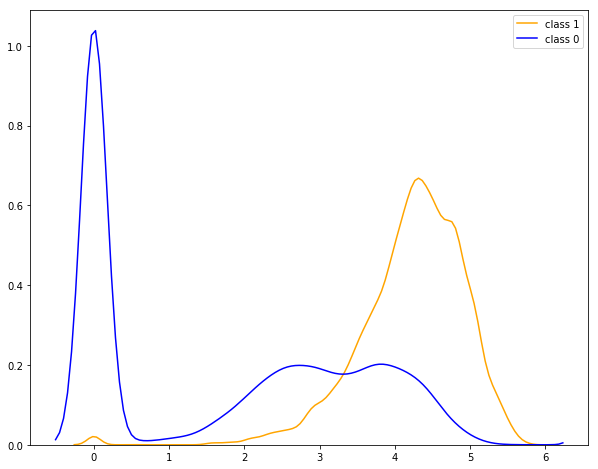

In [110]:
train_valid_0_unique =  train_valid[train_valid.LABEL == 0]
train_valid_1_unique =  train_valid[train_valid.LABEL == 1]


print(sum(train_valid_1_unique["MAX(data.R_VALUE)"] < 1.5))
xx_1 = train_valid_1_unique["MAX(data.R_VALUE)"]
xx_0 = train_valid_0_unique["MAX(data.R_VALUE)"]

plt.figure(figsize=(10,8))

sns.kdeplot(xx_1, label="class 1", color = "orange")
sns.kdeplot(xx_0, label="class 0", color = "blue", )

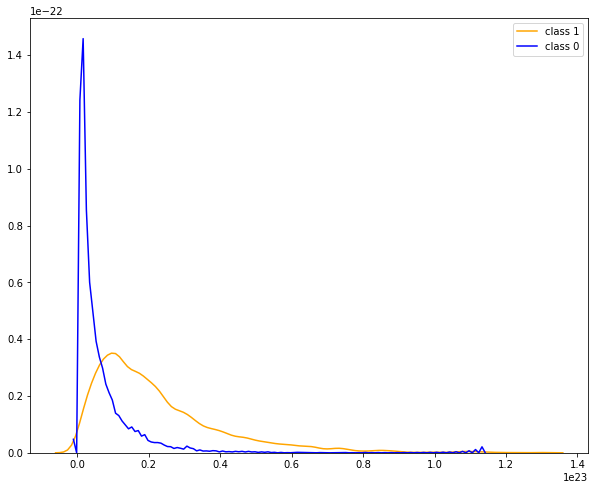

In [106]:
plt.figure(figsize=(10,8))
x_0 = train_valid_0_unique["MAX(data.R_VALUE)"] + train_valid_0_unique["MAX(data.USFLUX)"]
x_1 = train_valid_1_unique["MAX(data.R_VALUE)"] + train_valid_1_unique["MAX(data.USFLUX)"]
sns.kdeplot(x_1, label="class 1", color = "orange")
sns.kdeplot(x_0, label="class 0", color = "blue")

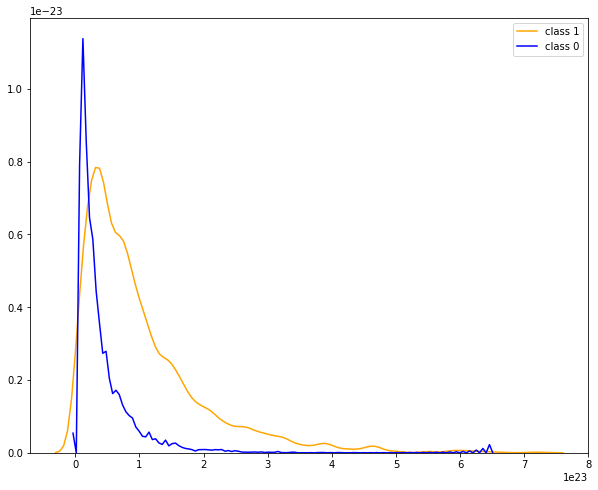

In [104]:
plt.figure(figsize=(10,8))
x_0 = train_valid_0_unique["MAX(data.R_VALUE)"] * train_valid_0_unique["MAX(data.USFLUX)"]
x_1 = train_valid_1_unique["MAX(data.R_VALUE)"] * train_valid_1_unique["MAX(data.USFLUX)"]
sns.kdeplot(x_1, label="class 1", color = "orange")
sns.kdeplot(x_0, label="class 0", color = "blue")

In [55]:
#write

import pickle
with open('../../models/lgb_.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open('../../models/lgb_no_SMOTE_withoutSUM.pickle', 'rb') as handle:
    lgb_model = pickle.load(handle)


In [74]:
lgb_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': {0: 1.0, 1: 2.5584415584415585},
 'colsample_bytree': 0.5,
 'importance_type': 'gain',
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 20000,
 'n_jobs': 8,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 0.5,
 'subsample_for_bin': 200000,
 'subsample_freq': 16,
 'seed': 2019,
 'metric': ['ff1', 'binary_logloss']}

In [75]:
y_pred_valid_prob = lgb_model.predict_proba(X_valid)
y_pred_valid_prob

array([[0.44665311, 0.55334689],
       [0.7063664 , 0.2936336 ],
       [0.80366872, 0.19633128],
       ...,
       [0.46395604, 0.53604396],
       [0.81404378, 0.18595622],
       [0.75487325, 0.24512675]])

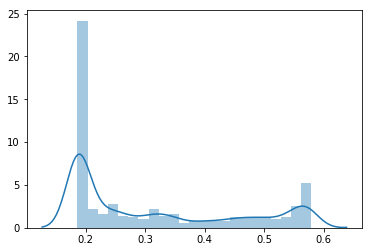

In [76]:
import seaborn as sns
sns.distplot(y_pred_valid_prob[:,1])

In [ ]:
valid_df = pd.DataFrame(data={"pred": (y_pred_valid_prob[:,1]), "label": y_valid})
valid_df.to_csv("../../data/intermediate/lgb_65078.csv", index=False)
valid_df.shape

In [77]:
pred_label_prob = lgb_model.predict_proba(X_submission)

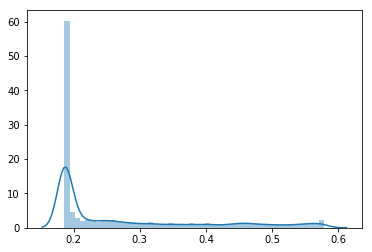

In [78]:
import seaborn as sns
sns.distplot(pred_label_prob[:,1])

In [79]:
%run "/data/zmining/jupyter-notebook/chaupm3/Age/src/visualization/common_visualization.py"
%run "/data/zmining/jupyter-notebook/chaupm3/Age/src/data_preparation/utils.py"


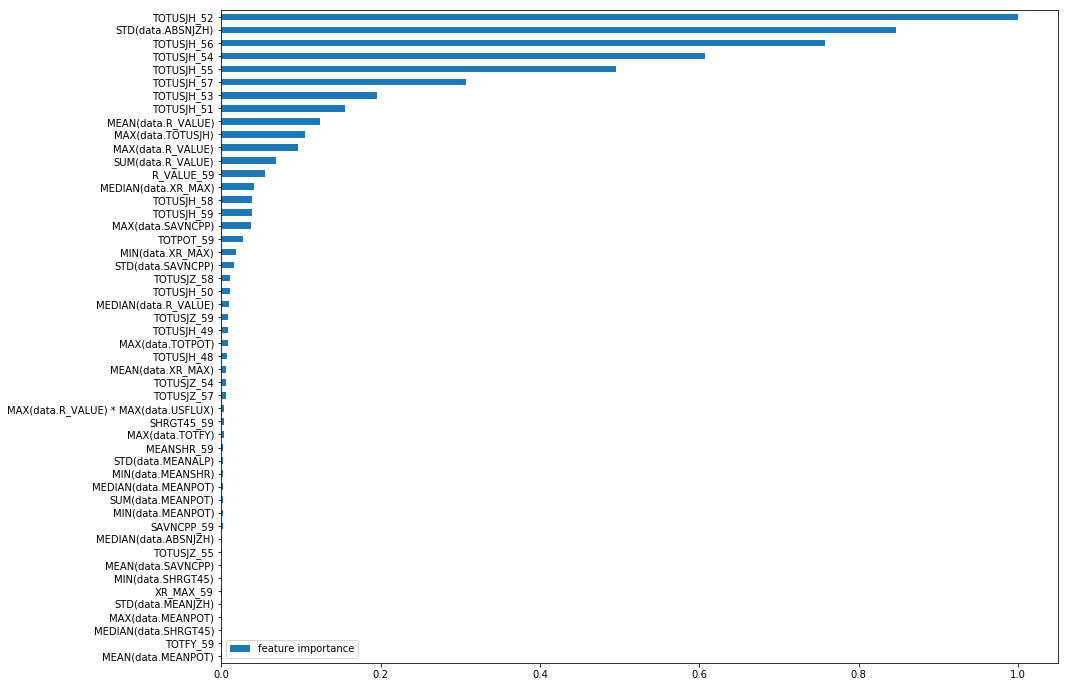

In [80]:
plot_feature_importance_lgb(lgb_model.feature_importances_, feature_cols, figsize=(15,12))

In [81]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_train)
shap.initjs()

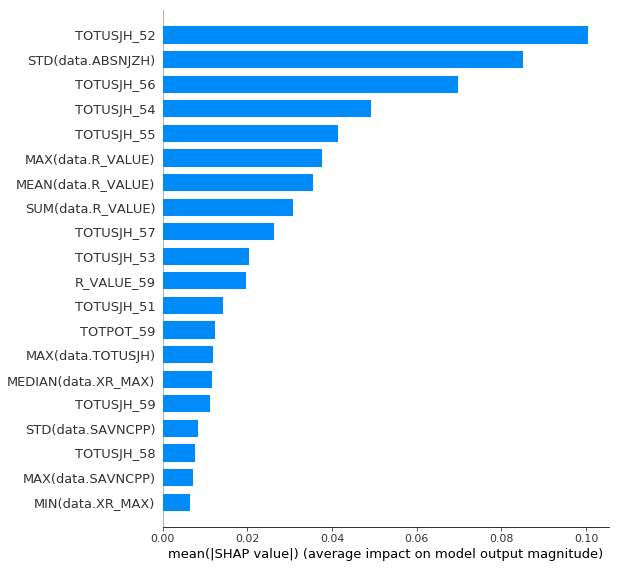

In [82]:
max_display = 20
shap.summary_plot(shap_values, X_train, feature_names=feature_cols, max_display = max_display, plot_type = "bar")

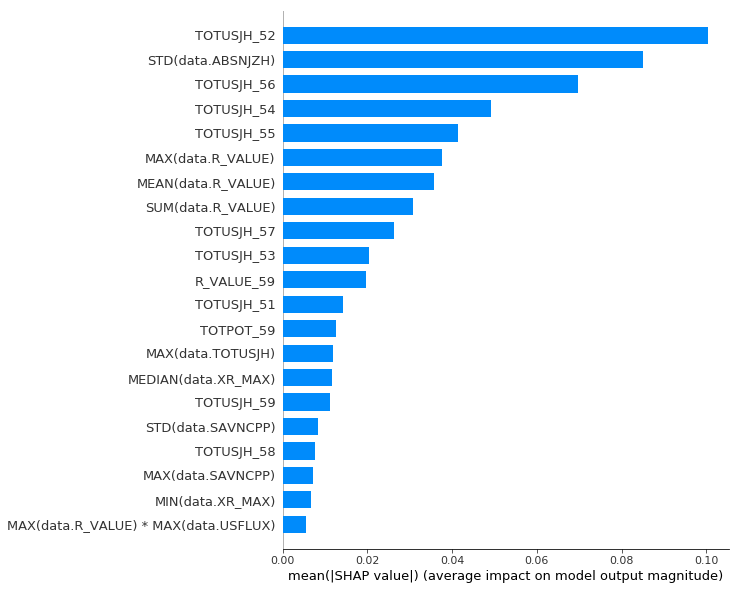

In [85]:
max_display = 21
shap.summary_plot(shap_values, X_train, feature_names=feature_cols, max_display = max_display, plot_type = "bar")

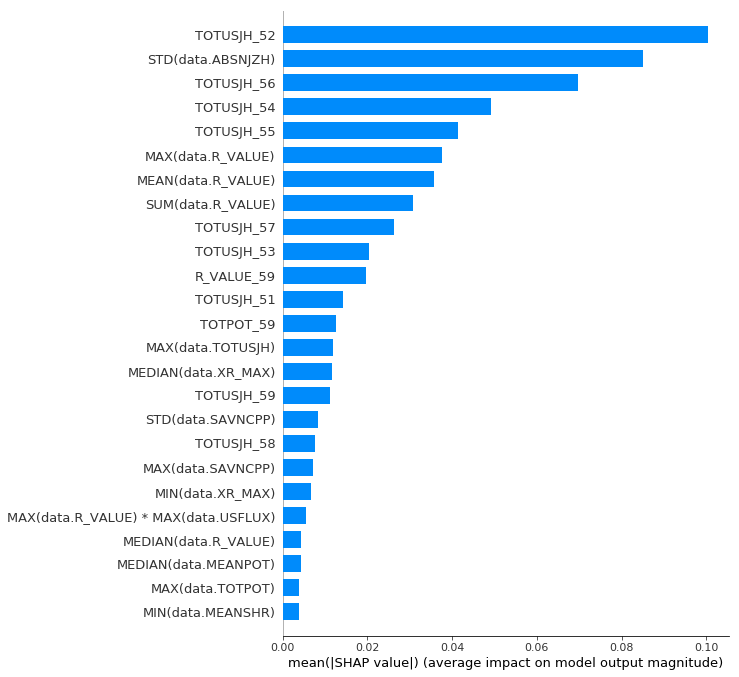

In [83]:
max_display = 25
shap.summary_plot(shap_values, X_train, feature_names=feature_cols, max_display = max_display, plot_type = "bar")

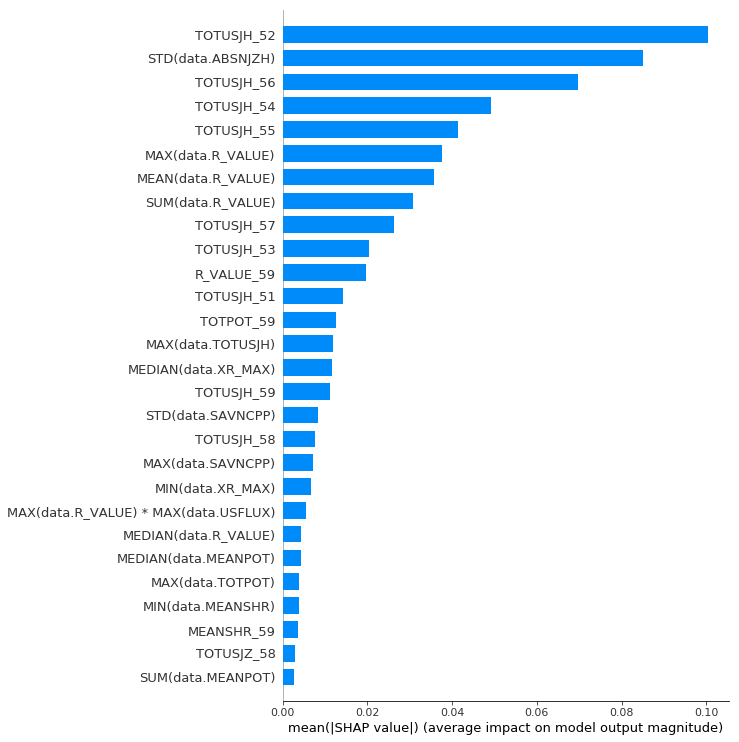

In [86]:
max_display = 28
shap.summary_plot(shap_values, X_train, feature_names=feature_cols, max_display = max_display, plot_type = "bar")

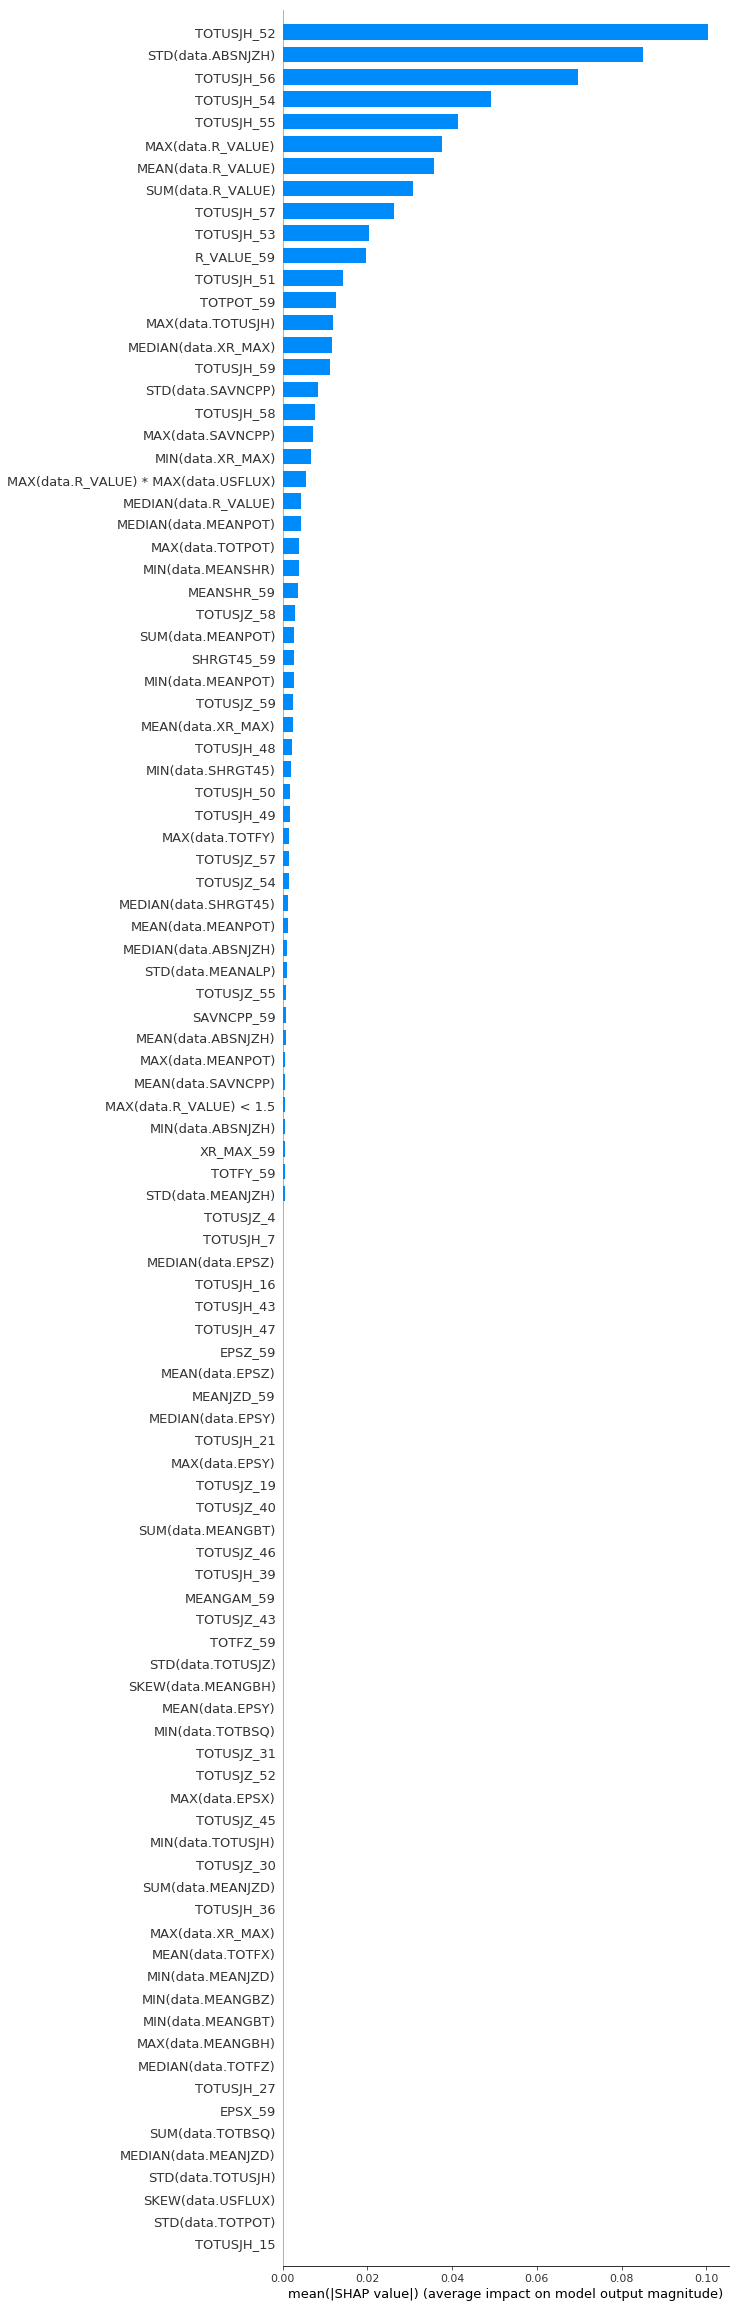

In [84]:
max_display = 100
shap.summary_plot(shap_values, X_train, feature_names=feature_cols, max_display = max_display, plot_type = "bar")

In [27]:
#### SUBMISSION

thres = 0.5
pred_labels = pred_label_prob[:,1] > thres
submission_df = pd.DataFrame({"Id": submission.ID, "ClassLabel": list(pred_labels)})
print(Counter(submission_df.ClassLabel))
submission_df.ClassLabel = submission_df.ClassLabel.astype(int)

submission_df.to_csv("../../data/output/ouput_{}.csv".format(str("717")), index=False)
submission_df.head(10)

# Counter({0: 141287, 1: 32225})


Counter({False: 141327, True: 32185})


,Id,ClassLabel
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0
5,6,1
6,7,0
7,8,0
8,9,0
9,10,1


In [41]:
submit_prob_df = pd.DataFrame(data={"pred": (pred_label_prob[:,1]), "label": [np.nan]*len(pred_label_prob)})
submit_prob_df.to_csv("../../data/intermediate/lgb_65078_sub_thres0.5.csv", index=False)
submit_prob_df.shape

(173512, 2)